# Biotransformation Project

In [80]:
import os
import sys
import pandas as pd
import numpy as np
from matchms.importing import load_from_mgf
from matchms.filtering import default_filters
from matchms.filtering import normalize_intensities
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from matchms.exporting import save_as_mgf
from typing import List
import pyteomics.mgf as py_mgf
from matchms.Spectrum import Spectrum
from matchms import Scores, Spectrum
from matchms import filtering, similarity
from tqdm.auto import tqdm
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Processing area file

In [2]:
#read the msdial output for both positive and negative mode data.
df_n = pd.read_csv("./MSDIAL_OUTPUT/P2_N/Area_0_202110261855.txt", sep='\t',skiprows=4)
df_p = pd.read_csv("./MSDIAL_OUTPUT/P2_P/Area_0_20211026163.txt", sep='\t',skiprows=4)

In [3]:
df_n.iloc[0:5,32:51]

,BLANK_N1,CVL2091_N1,CVL2092_N1,CVL2103_N1,CVL2106_N1,CVL2276_N1,CVL2277-N1,B_N1,P2_1ug_lm,P2_100ug_lm,P2-P_C1-LM,Control-2: (-)STD + LM,B,B_N1.1,P2_1ug_lm.1,P2_100ug_lm.1,P2-P_C1-LM.1,Control-2: (-)STD + LM.1,B.1
0,0,0,0,138779,0,0,0,0.000000,0.000000e+00,0.0,1.387793e+05,0.0,0.000000e+00,0,0,0,0,0,0.000000e+00
1,0,0,0,6915653,0,21759608,25438520,0.000000,0.000000e+00,0.0,6.915653e+06,0.0,2.359906e+07,0,0,0,0,0,2.601384e+06
2,0,335623936,270704064,0,327437408,0,0,0.000000,3.356239e+08,270704064.0,0.000000e+00,327437408.0,0.000000e+00,0,0,0,0,0,0.000000e+00
3,0,0,0,598750,0,0,140051,0.000000,0.000000e+00,0.0,5.987500e+05,0.0,7.002541e+04,0,0,0,0,0,9.903088e+04
4,124556,2106189,0,0,0,0,0,124556.046875,2.106189e+06,0.0,0.000000e+00,0.0,0.000000e+00,0,0,0,0,0,0.000000e+00


In [4]:
print(df_n.shape, df_p.shape)

(9300, 51) (13145, 51)


In [5]:
df_ms2_n = df_n.loc[df_n['MS/MS assigned'] == True]   # select features with MS/MS assigned in H-column
df_ms2_p = df_p.loc[df_p['MS/MS assigned'] == True]   # select features with MS/MS assigned in H-column
print(df_ms2_n.shape, df_ms2_p.shape)

(3321, 51) (3811, 51)


In [6]:
df_ms2_n.head(2)

,Alignment ID,Average Rt(min),Average Mz,Metabolite name,Adduct type,Post curation result,Fill %,MS/MS assigned,Reference RT,Reference m/z,...,P2_100ug_lm,P2-P_C1-LM,Control-2: (-)STD + LM,B,B_N1.1,P2_1ug_lm.1,P2_100ug_lm.1,P2-P_C1-LM.1,Control-2: (-)STD + LM.1,B.1
1,1,1.366,100.94583,Unknown,[M-H]-,found in higher mz's MsMs_574,0.429,True,NaN,NaN,...,0.0,6915653.0,0.0,23599064.0,0,0,0,0,0,2.601384e+06
2,2,1.201,101.02414,L-(+)-Erythrulose,[M-H]-,found in higher mz's MsMs_301; adduct linked t...,0.429,True,NaN,101.0244,...,270704064.0,0.0,327437408.0,0.0,0,0,0,0,0,0.000000e+00


In [7]:
#pd.Series(list(df.columns))

In [8]:
df_a_n = df_ms2_n.loc[df_ms2_n['BLANK_N1']!=0]   # step a; select all the spectra from System blank, 'AG' or 'AN' column, select non-zero.
df_a_p = df_ms2_p.loc[df_ms2_p['BLANK_P1']!=0]   # step a; select all the spectra from System blank, 'AG' or 'AN' column, select non-zero.

print(df_a_n.shape, df_a_p.shape)

(438, 51) (992, 51)


In [9]:
df_b_n = df_ms2_n.loc[df_ms2_n['B']!=0]          # step b; select all the spectra from Extraction blank, 'AS' column, select non-zero.
df_b_p = df_ms2_p.loc[df_ms2_p['B']!=0]          # step b; select all the spectra from Extraction blank, 'AS' column, select non-zero.

print(df_b_n.shape, df_b_p.shape)

(1053, 51) (1561, 51)


In [73]:
df_c_n = df_ms2_n.loc[df_ms2_n['Control-2: (-)STD + LM']!=0] # step c; select all the spectra from Liver only(negative contol), 'AK' or AR' column, select non-zero.
df_c_p = df_ms2_p.loc[df_ms2_p['Control-2: (-)STD + LM']!=0] # step c; select all the spectra from Liver only(negative contol), 'AK' or AR' column, select non-zero.

print(df_c_n.shape, df_c_p.shape)

(1512, 51) (1750, 51)


In [11]:
noise_df_n = pd.concat([df_a_n, df_b_n, df_c_n])          # step d; pool the spectra from step a, b and c to get the noise spectra
noise_df_p = pd.concat([df_a_p, df_b_p, df_c_p])          # step d; pool the spectra from step a, b and c to get the noise spectra

print(noise_df_n.shape, noise_df_p.shape)

(3003, 51) (4303, 51)


In [12]:
df_d_n = noise_df_n.drop_duplicates(keep='first')      # remove the duplicates from the noise.
df_d_p = noise_df_p.drop_duplicates(keep='first')      # remove the duplicates from the noise.

print(df_d_n.shape, df_d_p.shape)

(2358, 51) (3073, 51)


In [13]:
df_e_n = df_ms2_n.loc[(df_ms2_n['P2_1ug_lm']!=0) | (df_ms2_n['P2_100ug_lm']!=0)] #step e; select all the spectra from yyy and hepatic (present in either of two concn.), ('AH' or AO') and ('AI', AP') column, select non-zero.
df_e_p = df_ms2_p.loc[(df_ms2_p['P2_1ug_lm']!=0) | (df_ms2_p['P2_100ug_lm']!=0)] #step e; select all the spectra from yyy and hepatic (present in either of two concn.), ('AH' or AO') and ('AI', AP') column, select non-zero.

print(df_e_n.shape, df_e_p.shape) 

(2159, 51) (2264, 51)


In [14]:
df_f_n = df_ms2_n.loc[df_ms2_n['P2-P_C1-LM']!=0]   # step f; yyy only spectra, select the non-zero form 'AJ' or 'AQ' column 
df_f_p = df_ms2_p.loc[df_ms2_p['P2-P_C1-LM']!=0]   # step f; yyy only spectra, select the non-zero form 'AJ' or 'AQ' column 

print(df_f_n.shape, df_f_p.shape)                               

(999, 51) (1472, 51)


## Summary of source of spectra

In [74]:
spectra_summary_n = {'Source':['Total_MS2_Features', 'Sysem_blank(a)', 'Extraction_blank(b)', 'hepatic(c)', 'Combined_noise(d)', 'yyy_and_liver(e)', 'yyy_only(f)'], 'Number': [df_ms2_n.shape[0], df_a_n.shape[0], df_b_n.shape[0], df_c_n.shape[0], df_d_n.shape[0], df_e_n.shape[0], df_f_n.shape[0]]}
spectra_summary_p = {'Source':['Total_MS2_Features', 'Sysem_blank(a)', 'Extraction_blank(b)', 'hepatic(c)', 'Combined_noise(d)', 'yyy_and_liver(e)', 'yyy_only(f)'], 'Number': [df_ms2_p.shape[0], df_a_p.shape[0], df_b_p.shape[0], df_c_p.shape[0], df_d_p.shape[0], df_e_p.shape[0], df_f_p.shape[0]]}

spectra_summary_df_n = pd.DataFrame(spectra_summary_n)
spectra_summary_df_p = pd.DataFrame(spectra_summary_p)

print(spectra_summary_df_n.shape, spectra_summary_df_p.shape)

(7, 2) (7, 2)


In [2]:
sns.barplot(data=spectra_summary_df_n.set_index('Source').T, palette="Set1")
plt.xticks(rotation=35)
plt.tick_params(labelsize=26)
plt.title('Feature Summary P2_N', fontsize=26, weight='bold', color='red')
plt.xlabel("Study groups", size=26, weight='bold')    
plt.ylabel("Number of features", size=26, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle="--")
plt.rcParams["figure.figsize"] = (12, 12)

In [1]:
#spectra_summary_df_n.set_index('Source').T.plot.bar()
#spectra_summary_df_p.set_index('Source').T.plot.bar()

sns.barplot(data=spectra_summary_df_p.set_index('Source').T, palette="Set1")
plt.xticks(rotation=35)
plt.tick_params(labelsize=26)
plt.title('Feature Summary P2_P', fontsize=26, weight='bold', color='red')
plt.xlabel("Study groups", size=26, weight='bold')    
plt.ylabel("Number of features", size=26, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle="--")
plt.rcParams["figure.figsize"] = (12, 12)

## Spectra metadata reformating

In [17]:
## Function for reading the spectra from the mgf file of MSDIAL output.
# define a function to retrive spectra information from MS-DIAL output
def row_to_spec(row):
    mzs, intensities = list(zip(*[mzint.split(':')
                            for mzint in row['MS/MS spectrum'].rstrip().split(' ')]))

    metadata = {}
    for key in row.index[0:5]: #first five column index as metadata
        metadata[key] = row.get(key)
    metadata['precursor_mz'] = metadata.pop('Average Mz')
    metadata['retentiontime'] = metadata.pop('Average Rt(min)')
    metadata['compound_name'] = metadata.pop('Metabolite name') 
    metadata['precursortype'] = metadata.pop('Adduct type')
    #print(metadata)

    return Spectrum(mz=np.array(mzs, float),
                    intensities=np.array(intensities, float),
                    metadata=metadata
                   )


In [18]:
#df_d_spectra[0].metadata

In [19]:
# all noise spectra
df_d_n_spectra = df_d_n.apply(row_to_spec, axis=1).values
df_d_p_spectra = df_d_p.apply(row_to_spec, axis=1).values

print(len(df_d_n_spectra), len(df_d_p_spectra))

2358 3073


In [20]:
# spectra from yyy and hepatic
df_e_n_spectra = df_e_n.apply(row_to_spec, axis=1).values
df_e_p_spectra = df_e_p.apply(row_to_spec, axis=1).values

print(len(df_e_n_spectra), len(df_e_p_spectra))

2159 2264


In [21]:
# spectra from yyy only
df_f_n_spectra = df_f_n.apply(row_to_spec, axis=1).values
df_f_p_spectra = df_f_p.apply(row_to_spec, axis=1).values

print(len(df_f_n_spectra), len(df_f_p_spectra))

999 1472


# Cosine Score

## Define Score

In [22]:
from typing import List, Optional, Tuple
from collections import namedtuple
import numba as nb
import numpy as np
from matchms.Spectrum import Spectrum
import math

SpectrumTuple = namedtuple(
    "SpectrumTuple", ["precursor_mz", "precursor_charge", "mz", "intensity"]
)

def norm_int(intensity):
    norm = np.linalg.norm(intensity)
    return intensity if math.isclose(norm, 1) else np.copy(intensity) / norm

def cosine(
    spec: Spectrum,
    spec_other: Spectrum,
    fragment_mz_tolerance: float,
    allow_shift: bool,
):

    spec1 = SpectrumTuple(
        spec.metadata["precursor_mz"],
        spec.metadata["charge"],
        spec.peaks.mz,
        norm_int(spec.peaks.intensities),
    )
    spec2 = SpectrumTuple(
        spec_other.metadata["precursor_mz"],
        spec_other.metadata["charge"],
        spec_other.peaks.mz,
        norm_int(spec_other.peaks.intensities),
    )

    return _cosine(
        spec1,
        spec2,
        fragment_mz_tolerance,
        allow_shift,
    )


@nb.njit
def _cosine(
    spec: SpectrumTuple,
    spec_other: SpectrumTuple,
    fragment_mz_tolerance: float,
    allow_shift: bool,
) -> Tuple[float, List[Tuple[int, int]]]:
    """
    Compute the cosine similarity between the given spectra.
    Parameters
    ----------
    spec : SpectrumTuple
        Numba-compatible tuple containing information from the first spectrum.
    spec_other : SpectrumTuple
        Numba-compatible tuple containing information from the second spectrum.
    fragment_mz_tolerance : float
        The fragment m/z tolerance used to match peaks in both spectra with
        each other.
    allow_shift : bool
        Boolean flag indicating whether to allow peak shifts or not.
    Returns
    -------
    Tuple[float, List[Tuple[int, int]]]
        A tuple consisting of (i) the cosine similarity between both spectra,
        and (ii) the indexes of matching peaks in both spectra.
    """

    # Find the matching peaks between both spectra, optionally allowing for
    # shifted peaks.
    # Candidate peak indices depend on whether we allow shifts
    # (check all shifted peaks as well) or not.
    # Account for unknown precursor charge (default: 1).
    precursor_charge = max(abs(spec.precursor_charge), 1)
    precursor_mass_diff = (
        spec.precursor_mz - spec_other.precursor_mz
    ) * precursor_charge
    # Only take peak shifts into account if the mass difference is relevant.
    num_shifts = 1
    if allow_shift and abs(precursor_mass_diff) >= fragment_mz_tolerance:
        num_shifts += precursor_charge
    other_peak_index = np.zeros(num_shifts, np.uint16)
    mass_diff = np.zeros(num_shifts, np.float32)
    for charge in range(1, num_shifts):
        mass_diff[charge] = precursor_mass_diff / charge

    # Find the matching peaks between both spectra.
    peak_match_scores, peak_match_idx = [], []
    for peak_index, (peak_mz, peak_intensity) in enumerate(
        zip(spec.mz, spec.intensity)
    ):
        # Advance while there is an excessive mass difference.
        for cpi in range(num_shifts):
            while other_peak_index[cpi] < len(spec_other.mz) - 1 and (
                peak_mz - fragment_mz_tolerance
                > spec_other.mz[other_peak_index[cpi]] + mass_diff[cpi]
            ):
                other_peak_index[cpi] += 1
        # Match the peaks within the fragment mass window if possible.
        for cpi in range(num_shifts):
            index = 0
            other_peak_i = other_peak_index[cpi] + index
            while (
                other_peak_i < len(spec_other.mz)
                and abs(
                    peak_mz - (spec_other.mz[other_peak_i] + mass_diff[cpi])
                )
                <= fragment_mz_tolerance
            ):
                peak_match_scores.append(
                    peak_intensity * spec_other.intensity[other_peak_i]
                )
                peak_match_idx.append((peak_index, other_peak_i))
                index += 1
                other_peak_i = other_peak_index[cpi] + index

    score, peak_matches = 0.0, []
    if len(peak_match_scores) > 0:
        # Use the most prominent peak matches to compute the score (sort in
        # descending order).
        peak_match_scores_arr = np.asarray(peak_match_scores)
        peak_match_order = np.argsort(peak_match_scores_arr)[::-1]
        peak_match_scores_arr = peak_match_scores_arr[peak_match_order]
        peak_match_idx_arr = np.asarray(peak_match_idx)[peak_match_order]
        peaks_used, other_peaks_used = set(), set()
        for peak_match_score, peak_i, other_peak_i in zip(
            peak_match_scores_arr,
            peak_match_idx_arr[:, 0],
            peak_match_idx_arr[:, 1],
        ):
            if (
                peak_i not in peaks_used
                and other_peak_i not in other_peaks_used
            ):
                score += peak_match_score
                # Save the matched peaks.
                peak_matches.append((peak_i, other_peak_i))
                # Make sure these peaks are not used anymore.
                peaks_used.add(peak_i)
                other_peaks_used.add(other_peak_i)

    return score, peak_matches

In [23]:
#query_spectra[0].metadata

## Define spectra dictionary

In [24]:
def to_dict(query):
    return {"m/z array": query.peaks.mz,
            "intensity array": query.peaks.intensities,
            "params": query.metadata}

# Match P2+LM (e) with the sopectra obtained from noise(d)

Mathod:Fast(er) Comparison; Greedy cosine with precursor windows

## Spectra data normalization

In [25]:
query_spectra_n = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec))) 
                 for spec in df_e_n_spectra]


reference_spectra_n = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                     for spec in df_d_n_spectra]

################## positive mode ##############

query_spectra_p = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec))) 
                 for spec in df_e_p_spectra]


reference_spectra_p = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                     for spec in df_d_p_spectra]


Added cleaned compound name: Mesaconate
Added cleaned compound name: 4-Hydroxybenzoic acid
Added cleaned compound name: 4-Hydroxybenzoic acid
Added cleaned compound name: DL-Phenylalanine
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Added cleaned compound name: L-Sorbose
Added cleaned compound name: Hydroxysebacic acid
Added cleaned compound name: Butanedioic acid, 2-(4,4-dimethyl-2-methylenepentyl)-
Added cleaned compound name: 6,7,8-trimethoxychromen-2-one [IIN-based: Match]
Added cleaned compound name: 3-(1-hydroxy-2-oxobutylidene)-6-[(E)-prop-1-enyl]pyran-2,4-dione
Removed formula C6H2F8O2 from compound name.
Added formula C6H2F8O2 to metadata.
Added c

Added cleaned compound name: 1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine-N,N-dimethyl
Added cleaned compound name: w/o MS2: 1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine-N,N-dimethyl
Added cleaned compound name: w/o MS2: 1,2-Dioleoyl-sn-glycero-3-phosphoethanolamine-N,N-dimethyl
Added cleaned compound name: [2-(4-hydroxy-3-methoxyphenyl)-4-[(4-hydroxy-3-methoxyphenyl)methyl]oxolan-3-yl]methyl (E)-3-(4-hydroxyphenyl)prop-2-enoate
Added cleaned compound name: 4,6-dihydroxy-3-(6-hydroxy-1-oxo-3-pentylisochromen-8-yl)oxy-2-pentylbenzoic acid
Added cleaned compound name: [4-[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxyphenyl]methyl 3-acetyloxy-2-hydroxy-2-[(4-hydroxyphenyl)methyl]butanoate [IIN-based: Match]
Added cleaned compound name: 9-Hydroxy-9-[({(2E)-2-(hydroxymethyl)-3-[3-(hydroxymethyl)-6-isopropyl-2-cyclohexen-1-yl]-2-propenoyl}oxy)methyl]-6-isopropyl-1-oxo-1,3,5a,6,7,8,9,9a-octahydro-2-benzoxepine-4-carboxylic acid
Added cleaned compound name: [1-[3-(3-hydroxy-2,2-dimethyl-1,

Removed formula C6H2F8O2 from compound name.
Added formula C6H2F8O2 to metadata.
Added cleaned compound name: w/o MS2:PFCA-perfluoroalkyl_Hsubstituted_1DB
Removed formula C5HF9O2 from compound name.
Added formula C5HF9O2 to metadata.
Added cleaned compound name: w/o MS2:PFCA-perfluoroalkyl_branched
Removed formula C6H3F9O2 from compound name.
Added formula C6H3F9O2 to metadata.
Added cleaned compound name: w/o MS2:FT-PFCA
Removed formula C6H3F9O2 from compound name.
Added formula C6H3F9O2 to metadata.
Added cleaned compound name: w/o MS2:FT-PFCA
Removed formula C6H3F9O2 from compound name.
Added formula C6H3F9O2 to metadata.
Added cleaned compound name: w/o MS2:FT-PFCA
Added cleaned compound name: Pregna-4,16-diene-3,20-dione
Removed adduct [M-H]- from compound name.
Added adduct [M-H]- to metadata.
Added cleaned compound name: 53FTA; LC-ESI-QQ; MS2; CE10
Removed adduct [M-H]- from compound name.
Added adduct [M-H]- to metadata.
Added cleaned compound name: 53FTA; LC-ESI-QQ; MS2; CE10


Added cleaned compound name: w/o MS2:2-BAHLIA [DMED-FAHFA]; [22:0-(2-O-24:0)]
Added cleaned compound name: w/o MS2:2-TTRAHLIA [DMED-FAHFA]; [24:3-(2-O-24:0)]
Added cleaned compound name: w/o MS2: N-Tetracosanoyl-4-sphingenyl-1-O-phosphorylcholine
Removed adduct [M+H]+; from compound name.
Added adduct [M+H]+; to metadata.
Added cleaned compound name: w/o MS2:2,6,8-Trimethyl-3-Amino-9-Benzyl-9-Methoxynonanoic Acid-CoA; (Acyl-CoA)
Added cleaned compound name: Mesaconate
Added cleaned compound name: DL-Phenylalanine
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula C2HF6O4P from compound name.
Added formula C2HF6O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-diPAP
Added cleaned compound name: 6,7,8-trimethoxychromen-2-one [IIN-based: Match]
Added cleaned compou

Added cleaned compound name: Arg-Ile
Added cleaned compound name: w/o MS2:Catechin
Added cleaned compound name: w/o MS2:Catechin
Added cleaned compound name: 2-[2-methyl-3-(trifluoromethyl)anilino]pyridine-3-carboxylic acid
Added cleaned compound name: Phe-Met
Added cleaned compound name: Phe-Met
Added cleaned compound name: Met-Phe
Added cleaned compound name: 12(13)-Epoxy-9Z-octadecenoic acid
Added cleaned compound name: Conjugated linoleic Acid (10E,12Z)  [IIN-based on: CCMSLIB00003136426]
Added cleaned compound name: Palmitoyl ethanolamide
Added cleaned compound name: 3,4,5,6-tetrachlorophthalic acid
Added cleaned compound name: 2-Phenylethyl beta-D-glucopyranoside
Added cleaned compound name: Benzyldodecyldimethylammonium
Added cleaned compound name: 1-Hexadecylpyridinium
Added cleaned compound name: 1-Hexadecylpyridinium
Added cleaned compound name: Convolvamine
Added cleaned compound name: N-Acetylphenylalanylvaline
Added cleaned compound name: w/o MS2: Pentapropylene glycol
Add

Added cleaned compound name: (4E,10E)-13,20-Dihydroxy-8,14-dimethoxy-4,10,12,16-tetramethyl-3-oxo-2-azabicyclo[16.3.1]docosa-1(22),4,10,18,20-pentaen-9-yl carbamate
Added cleaned compound name: 4-tert-butyl-N-[6-(2-hydroxyethoxy)-5-(2-methoxyphenoxy)-2-pyrimidin-2-ylpyrimidin-4-yl]benzenesulfonamide
Added cleaned compound name: (E)-5-(4-methoxy-5-methyl-6-oxopyran-2-yl)-3-methylhex-4-enoic acid [IIN-based on: CCMSLIB00000845558]
Added cleaned compound name: Cyclopenta[c]pyran-4-carboxylic acid, 1,4a,5,7a-tetrahydro-7-(hydroxymethyl)-1-[[6-O-[(2E)-3-(4-hydroxyphenyl)-1-oxo-2-propen-1-yl]-beta-D-glucopyranosyl]oxy]-, methyl ester
Added cleaned compound name: (3R,5R)-7-[2-(4-fluorophenyl)-3-phenyl-4-(phenylcarbamoyl)-5-propan-2-ylpyrrol-1-yl]-3,5-dihydroxyheptanoic acid
Added cleaned compound name: 3-[2-(3,4-Dihydroxyphenyl)-5,7-dihydroxy-4-oxo-4H-1-benzopyran-8
Added cleaned compound name: 2H-Cyclopenta[b]naphtho[2,3-d]furan-10-acetic acid, 5-(acetyloxy)-2-(3-furanyl)-3,3a,4a,5,5a,6,9,9a

Added cleaned compound name: Diethyl phthalate
Added cleaned compound name: 1,1-bis(oxidanylidene)-1,2-benzothiazol-3-one
Added cleaned compound name: 1,1-bis(oxidanylidene)-1,2-benzothiazol-3-one
Added cleaned compound name: w/o MS2: Dacarbazine
Added cleaned compound name: w/o MS2:[Precursor mass wrong]  Lauric acid leelamide
Added cleaned compound name: Diethyl phthalate  [IIN-based: Match]
Added cleaned compound name: 2-(6-hydroxy-6-methylheptyl)-2H-furan-5-one
Added cleaned compound name: (2S)-6-(2-hydroxyethyl)-2-(hydroxymethyl)-5,7-dimethyl-2,3-dihydroinden-1-one
Added cleaned compound name: 2-(7-hydroxy-6-methyloctyl)-2H-furan-5-one
Added cleaned compound name: 3-(5,6-dihydroxyheptyl)-4-methyl-2H-furan-5-one [IIN-based: Match]
Added cleaned compound name: 2-Methylbutyrylcarnitine
Added cleaned compound name: 2,4,6-tris(prop-2-enoxy)-1,3,5-triazine
Added cleaned compound name: 3-[(1R,2R)-2-[(dimethylamino)methyl]-1-hydroxycyclohexyl]phenol
Added cleaned compound name: Chlorhexid

Added cleaned compound name: 6-[3-[(3,4-dimethoxyphenyl)methyl]-4-methoxy-2-(methoxymethyl)butyl]-4-methoxy-1,3-benzodioxole [IIN-based on: CCMSLIB00000848625]
Added cleaned compound name: Nonaethylene glycol  [IIN-based on: CCMSLIB00003135822]
Added cleaned compound name: Nonaethylene glycol  [IIN-based on: CCMSLIB00003135822]
Added cleaned compound name: 2H-Oxireno[1,10a]phenanthro[3,2-b]furan-10(11bH)-one, 5,7-bis(acetyloxy)-3,3a,4,5,6,7,7a,7b,8,8a-decahydro-4,4,7a,11-tetramethyl-, (1aS,3aR,5S,7S,7aR,7bS,8aR,11bR)- [IIN-based on: CCMSLIB00000853048]
Added cleaned compound name: Nonaethylene glycol  [IIN-based on: CCMSLIB00003137287]
Added cleaned compound name: 6.N-Benzoylphenylalanylphenylalinol acetate
Added cleaned compound name: 3-[4-({2-[(2E)-2-Buten-2-yl]-6,8-dimethyl-1,2,4a,5,6,7,8,8a-octahydro-1-naphthalenyl}carbonyl)-3-hydroxy-5-oxo-2,5-dihydro-1H-pyrrol-2-yl]-2-hydroxy-2-methylpropanoic acid
Added cleaned compound name: 3-[4-({2-[(2E)-2-Buten-2-yl]-6,8-dimethyl-1,2,4a,5,6,

Added cleaned compound name: 3,6-bis(3,4,5-trimethoxyphenyl)-1,3,3a,4,6,6a-hexahydrofuro[3,4-c]furan
Added cleaned compound name: 3,6-bis(3,4,5-trimethoxyphenyl)-1,3,3a,4,6,6a-hexahydrofuro[3,4-c]furan
Added cleaned compound name: w/o MS2: Lyso-Sphingomyelin
Added cleaned compound name: 1-Myristoyl-sn-glycero-3-phosphocholine
Removed formula C12H21F7N2O6S2 from compound name.
Added formula C12H21F7N2O6S2 to metadata.
Added cleaned compound name: w/o MS2:PFSM-amine
Added cleaned compound name: (1'R,3'R,8'R,12'E,18'E,20'Z,24'R,25'S)-5',13',25'-Trimethyl-11'H,17'H,22'H-spiro[oxirane-2,26'-[2,10,16,23]tetraoxatetracyclo[22.2.1.0~3,8~.0~8,25~]heptacosa[4,12,18,20]tetraene]-11',17',22'-trione
Added cleaned compound name: (2S)-2-[[(2R)-2-[[1-[(2-methylpropan-2-yl)oxycarbonyl]-4-phenylpiperidine-4-carbonyl]amino]propanoyl]amino]-3-phenylpropanoic acid
Added cleaned compound name: 1-Kestose
Added cleaned compound name: (4E,10E)-13,20-Dihydroxy-8,14-dimethoxy-4,10,12,16-tetramethyl-3-oxo-2-azabi

## spectra comparision

In [26]:
greedy_scores_n = []
for qs in tqdm(query_spectra_n):
    for rs in reference_spectra_n:
        if abs(qs.metadata['precursor_mz'] - rs.metadata['precursor_mz']) > 2:        
            continue
        score = cosine(qs, rs, 0.2, False)
        greedy_scores_n.append((qs.metadata.get('compound_name') + '_' + str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

greedy_scores_n = pd.DataFrame(greedy_scores_n, columns = ['query_id','query_spec','score','number_matching_fragments'])


greedy_scores_p = []
for qs in tqdm(query_spectra_p):
    for rs in reference_spectra_p:
        if abs(qs.metadata['precursor_mz'] - rs.metadata['precursor_mz']) > 2:        
            continue
        score = cosine(qs, rs, 0.2, False)
        greedy_scores_p.append((qs.metadata.get('compound_name') + '_' + str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

greedy_scores_p = pd.DataFrame(greedy_scores_p, columns = ['query_id','query_spec','score','number_matching_fragments'])

print(greedy_scores_n.shape, greedy_scores_p.shape)

  0%|          | 0/2159 [00:00<?, ?it/s]

  0%|          | 0/2264 [00:00<?, ?it/s]

(30509, 4) (40083, 4)


In [27]:
greedy_scores_n.head(2)

,query_id,query_spec,score,number_matching_fragments
0,L-(+)-Erythrulose_12,<matchms.Spectrum.Spectrum object at 0x0000022...,0.512678,5
1,L-(+)-Erythrulose_12,<matchms.Spectrum.Spectrum object at 0x0000022...,1.000000,12


In [28]:
greedy_scores_p.head(2)

,query_id,query_spec,score,number_matching_fragments
0,Cyclohexylamine_6,<matchms.Spectrum.Spectrum object at 0x0000022...,0.080763,4
1,Cyclohexylamine_6,<matchms.Spectrum.Spectrum object at 0x0000022...,0.028337,2


In [29]:
#skip
"""
# modified_score has not been used in the downstream analysis because this is slow.
modified_scores = []
for qs in tqdm(query_spectra):
    for rs in reference_spectra:
        score = cosine(qs, rs, 0.2, True)
        modified_scores.append((qs.metadata.get('compound_name')+'_'+str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

modified_scores = pd.DataFrame(modified_scores, columns = ['query_id','query_spec','score','number_matching_fragments'])

modified_scores.shape
"""

"\n# modified_score has not been used in the downstream analysis because this is slow.\nmodified_scores = []\nfor qs in tqdm(query_spectra):\n    for rs in reference_spectra:\n        score = cosine(qs, rs, 0.2, True)\n        modified_scores.append((qs.metadata.get('compound_name')+'_'+str(len(qs.peaks.mz)), qs, score[0], len(score[1])))\n\nmodified_scores = pd.DataFrame(modified_scores, columns = ['query_id','query_spec','score','number_matching_fragments'])\n\nmodified_scores.shape\n"

In [30]:
#skip
#modified_scores.head(2)

In [31]:
selection_greedy_n = greedy_scores_n[(greedy_scores_n.score < 0.7) & (
    greedy_scores_n.number_matching_fragments < 5)].drop_duplicates(subset='query_id')

selection_greedy_p = greedy_scores_p[(greedy_scores_p.score < 0.7) & (
    greedy_scores_p.number_matching_fragments < 5)].drop_duplicates(subset='query_id')

print(len(selection_greedy_n), len(selection_greedy_p))


1201 1551


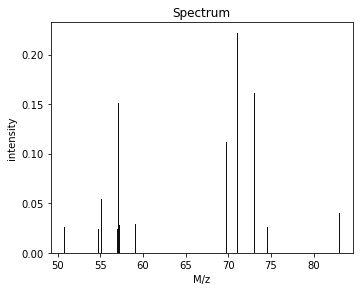

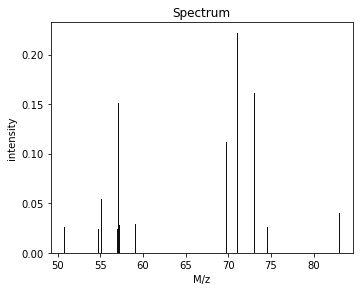

In [32]:
selection_greedy_n.query_spec.iloc[0].plot()

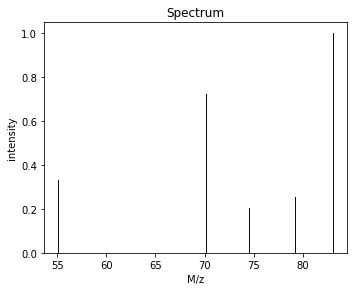

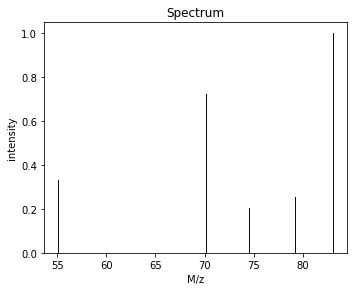

In [33]:
selection_greedy_p.query_spec.iloc[0].plot()

## Output

In [34]:
with open('./MSDIAL_OUTPUT/P2_N/P2+LM_output_greedy_less_than_07.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy_n.query_spec.apply(to_dict).values, f_out)
f_out.close()

with open('./MSDIAL_OUTPUT/P2_P/P2+LM_output_greedy_less_than_07.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy_p.query_spec.apply(to_dict).values, f_out)
f_out.close()



# P2+LM_output_greedy_less_than 0.7 list
e_d_match_n = selection_greedy_n.query_spec.to_list()
e_d_match_p = selection_greedy_p.query_spec.to_list()

print(len(e_d_match_n), len(e_d_match_p))

1201 1551


# Match yyy only spectra (f) with the spectra obtained from noise and yyy+HP spectra with <.7 cosine (e_d_match)

## Spectra data normalisation

In [35]:
query_spectra_n = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                 for spec in df_f_n_spectra]

"""
reference_spectra = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                     for spec in e_d_match]
"""
reference_spectra_n = e_d_match_n # as this is alredy normalized and cleaned.

####################### Positive mode ##############


query_spectra_p = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                 for spec in df_f_p_spectra]

reference_spectra_p = e_d_match_p # as this is alredy normalized and cleaned.


Added cleaned compound name: 4-Hydroxybenzoic acid
Added cleaned compound name: 4-Hydroxybenzoic acid
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Removed formula CH2F3O4P from compound name.
Added formula CH2F3O4P to metadata.
Added cleaned compound name: w/o MS2:PFAP-PAP
Added cleaned compound name: Methoxytyrosine
Added cleaned compound name: Hydroxysebacic acid
Added cleaned compound name: Butanedioic acid, 2-(4,4-dimethyl-2-methylenepentyl)-
Added cleaned compound name: 3-(1-hydroxy-2-oxobutylidene)-6-[(E)-prop-1-enyl]pyran-2,4-dione
Removed formula C6H2F8O2 from compound name.
Added formula C6H2F8O2 to metadata.
Added cleaned compound name: w/o MS2:PFCA-perfluoroalkyl_Hsubstituted_1DB
Removed formula C5HF9O2 from compound name.
Added formula C5HF9O2 to metadata.
Added cleane

Added cleaned compound name: w/o MS2:BML00234 {3,4,5-triacetyloxy-6-[5-acetyloxy-3-(4-methoxyphenyl)-4-oxochromen-6-yloxy]-2 H-3,4,5,6-tetrahydropyran-2-yl}methyl acetate
Added cleaned compound name: (2S,4R,9beta,16alpha,17xi,23E)-2-(beta-D-Glucopyranosyloxy)-16,20-dihydroxy-9,10,14-trimethyl-1,11,22-trioxo-4,9-cyclo-9,10-secocholesta-5,23-dien-25-yl acetate
Added cleaned compound name: Coumarin base + 1O, 1MeO, O-(C26H31O12)
Added cleaned compound name: Card-20(22)-enolide, 3-[(2,6-dideoxy-4-O-beta-D-glucopyranosyl-3-O-methyl-beta-D-ribo-hexopyranosyl)oxy]-5,14-dihydroxy-19-oxo-, (3beta,5beta)-
Added cleaned compound name: 2-[6-(2-methylbut-3-en-2-yl)-7-oxo-2,3-dihydrofuro[3,2-g]chromen-2-yl]propan-2-yl acetate [IIN-based on: CCMSLIB00000848402]
Added cleaned compound name: w/o MS2:2-TTRAHLIA [DMED-FAHFA]; [24:3-(2-O-24:0)]
Added cleaned compound name: (E)-3-(4-hydroxyphenyl)-N-[3-[[(E)-3-(4-hydroxyphenyl)prop-2-enoyl]-[4-[[(E)-3-(4-hydroxyphenyl)prop-2-enoyl]-[3-[[(E)-3-(4-hydroxyphe

Added cleaned compound name: Methyl (2S)-[(5S,6S,10S,12S,13R,15S,19S)-6-(3-furyl)-15,18-dihydroxy-1,5,16-trimethyl-8,14-dioxo-7,11-dioxahexacyclo[14.2.1.0~2,12~.0~5,10~.0~10,12~.0~13,18~]nonadec-19-yl](hydroxy)acetate
Added cleaned compound name: Methyl (2S)-[(5S,6S,10S,12S,13R,15S,19S)-6-(3-furyl)-15,18-dihydroxy-1,5,16-trimethyl-8,14-dioxo-7,11-dioxahexacyclo[14.2.1.0~2,12~.0~5,10~.0~10,12~.0~13,18~]nonadec-19-yl](hydroxy)acetate
Added cleaned compound name: 3-ethenyl-4-[2-(3,4,5-trihydroxybenzoyl)oxyethyl]-2-[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy-3,4-dihydro-2H-pyran-5-carboxylic acid
Added cleaned compound name: 4-tert-butyl-N-[6-(2-hydroxyethoxy)-5-(2-methoxyphenoxy)-2-pyrimidin-2-ylpyrimidin-4-yl]benzenesulfonamide
Added cleaned compound name: (E)-5-(4-methoxy-5-methyl-6-oxopyran-2-yl)-3-methylhex-4-enoic acid [IIN-based on: CCMSLIB00000845558]
Added cleaned compound name: Cyclopenta[c]pyran-4-carboxylic acid, 1,4a,5,7a-tetrahydro-7-(hydroxymethyl)-1-[[6-O-[(2E)-3-(4-hy

## Spectra Comparision

In [36]:
greedy_scores_n = []
for qs in tqdm(query_spectra_n):
    for rs in reference_spectra_n:
        if abs(qs.metadata['precursor_mz'] - rs.metadata['precursor_mz']) > 2:        
            continue
        score = cosine(qs, rs, 0.2, False)
        greedy_scores_n.append((qs.metadata.get('compound_name') + '_' + str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

greedy_scores_n = pd.DataFrame(greedy_scores_n, columns = ['query_id','query_spec','score','number_matching_fragments'])

greedy_scores_p = []
for qs in tqdm(query_spectra_p):
    for rs in reference_spectra_p:
        if abs(qs.metadata['precursor_mz'] - rs.metadata['precursor_mz']) > 2:        
            continue
        score = cosine(qs, rs, 0.2, False)
        greedy_scores_p.append((qs.metadata.get('compound_name') + '_' + str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

greedy_scores_p = pd.DataFrame(greedy_scores_p, columns = ['query_id','query_spec','score','number_matching_fragments'])

print(greedy_scores_n.shape, greedy_scores_p.shape)

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/1472 [00:00<?, ?it/s]

(7223, 4) (14417, 4)


In [37]:
greedy_scores_n.head(2)

,query_id,query_spec,score,number_matching_fragments
0,Unknown_15,<matchms.Spectrum.Spectrum object at 0x0000022...,0.512678,5
1,Unknown_18,<matchms.Spectrum.Spectrum object at 0x0000022...,0.122400,2


In [38]:
greedy_scores_p.head(2)

,query_id,query_spec,score,number_matching_fragments
0,Cyclohexylamine_6,<matchms.Spectrum.Spectrum object at 0x0000022...,1.000000,6
1,Cyclohexylamine_6,<matchms.Spectrum.Spectrum object at 0x0000022...,0.463114,2


In [39]:
selection_greedy_n = greedy_scores_n[(greedy_scores_n.score < 0.7) & (
    greedy_scores_n.number_matching_fragments < 5)].drop_duplicates(subset='query_id')

selection_greedy_p = greedy_scores_p[(greedy_scores_p.score < 0.7) & (
    greedy_scores_p.number_matching_fragments < 5)].drop_duplicates(subset='query_id')

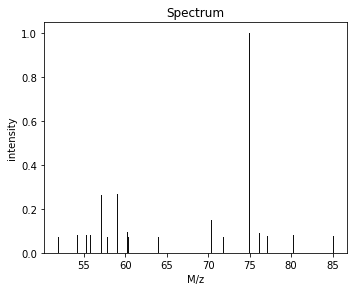

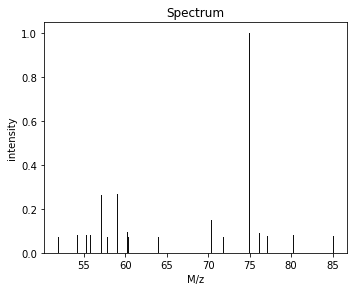

In [40]:
selection_greedy_n.query_spec.iloc[0].plot()

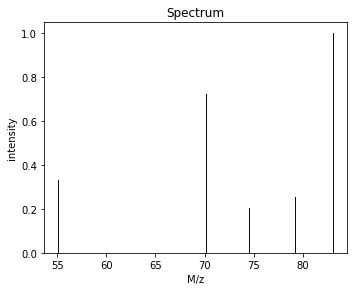

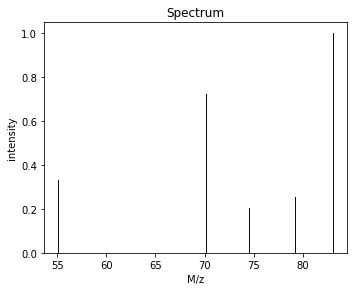

In [41]:
selection_greedy_p.query_spec.iloc[0].plot()

## output

In [42]:
with open('./MSDIAL_OUTPUT/P2_N/P2_N_biotrnasformant.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy_n.query_spec.apply(to_dict).values, f_out)
f_out.close()

with open('./MSDIAL_OUTPUT/P2_P/P2_P_biotrnasformant.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy_p.query_spec.apply(to_dict).values, f_out)
f_out.close()



# P2_output_greedy_less_than 0.7 list
e_d_f_match_n = selection_greedy_n.query_spec.to_list()
e_d_f_match_p = selection_greedy_p.query_spec.to_list()

print(len(e_d_f_match_n), len(e_d_f_match_p))

555 920


In [43]:
# Combined biotransformed spectra
g_spectra = e_d_f_match_n + e_d_f_match_p

len(g_spectra)

1475

# Liver  InSilico Data Analysis
[data](https://drive.google.com/drive/folders/1lB8dd3JnUWkn9fk9bD6qKZvrhULPLhOO)

This is the in-silico way of biotransformation

Data: C:\Users\kunda\OneDrive\Desktop\WORK\Biotransformation

## Preprocess the data as given in the preprocessing step
	Output: list of smiles which crossponds to the list of compunds from a yyy.

STEPS:
1. Change the the code name with actual name and run the following commands
   grep -i "P2"  9000_priority_yyy_chemicals_with_names.txt >P2
   grep -i "P10" 9000_priority_yyy_chemicals_with_names.txt >P10
   grep -i "P18" 9000_priority_yyy_chemicals_with_names.txt >P18

2. cat P2 P10 P19  > chemicals_from_P2_P10_and_P18.txt	#Concatenate the files obtained from first step.

3. Extract all the lines from chemicals_from_P2_P10_and_P18.txt that contain the smiles informations for the compunds using excel or any other means and save in the chemicals_from_P2_P10_and_P18_with_smiles.txt. 

4. grep the lines that belongs to P2, P10 and P18 in the chemicals_from_P2_P10_and_P18_with_smiles.txt and save in the P2_with_smiles P10_with_smiles and P18_with_smiles.
    grep "P2" chemicals_from_P2_P10_and_P18_with_smiles.txt > P2_with_smiles ## Change P2 with actual name in the command and similarly for P10 and P18.

5. Remove redundancy from P2_with_smiles, P10_with_smiles and P18_with_smiles and save in the files P2_with_smiles_unique, P10_with_smiles_unique and P18_with_smiles_unique respectively
    sort -u P2_with_smiles  >P2_with_smiles_unique 	# similarly for P10 and P18

6. Save the list of smiles for the compounds present each yyy in 
   cut -f11 P2 >P2_unique_smiles_only	# and so for P10 and P18



## Once having a list of smiles Biotransformation study can done with following command:

	java -jar biotransformer-1.1.5.jar  -k pred -b allHuman -ismi "CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C)C(C)C" -osdf outfile1 -s 2 -t 0.01 -a

	Output: output for the biotransformer is an sdf file for example here it is outfile1.sdf

  In our study we have 383 compunds from P2, P10 and P18. So we run in a bach and the bash script for that is biotransformer.sh.
  So, we have 383 output file as outfile1, outfile2,.... to outfile383.
  outfile1 - outfle69 belongs to P2 (outfile55 could not be predicted) So further analysis will be for 68 compound only.
  outfile70 - outfile240 belongs to P10 and
  outfile241 - outfile383 belongs to P18

  
## Rename these biotransformed output by giving .sdf extension to them.(This is an extra step as we have not provided the extension in the biotransformation output).
	eg. outfile1 outfile.sdf. Command for doing this is

	for i in outfile*; do mv "$i" "$i".sdf; done;

   Convert these output from biotrnsformer in sdf to smiles with openbabel gui.

	Input : outfile*.sdf
	Output : outfile*
## predict the spectra using the CFM-ID with the command given below and the bash file are give in in each yyy folder.
	cfm-predict '/cfmid/P2/outfile1.txt' 0.001 /trained_models_cfmid4.0/[M-H]-/param_output.log /trained_models_cfmid4.0/[M-H]-/param_config.txt 1 '/cfmid/P2/outfile1'

	a.) The parse the output of the CFM-ID using the the parse_cfmid.py. bash file for parsing are in the corrosponding yyy folder.

## convert the .msp file to .mgf file
	first concatenate all msp file from a yyy into single file and then use the MSP2MGF v1.3 a tool to convert .msp to .mgf.



# match biotransformed compund spectra (g) with spectra from cfmid

## read biotransformed spectra as reference to match

In [44]:
with open("C:/Users/kunda/OneDrive/Desktop/WORK/Biotransformation/5_msp_to_mgf/P2/combined/P2_combined.mgf", "r") as fq:
    content = fq.read()
with open("C:/Users/kunda/OneDrive/Desktop/WORK/Biotransformation/5_msp_to_mgf/P2/combined/P2_combined_formated.mgf", "w") as fq:
    fq.write(content.replace('#',''))

In [45]:
bt_spectra = [spec for spec in tqdm(load_from_mgf("C:/Users/kunda/OneDrive/Desktop/WORK/Biotransformation/5_msp_to_mgf/P2/combined/P2_combined_formated.mgf"))]
len(bt_spectra)

0it [00:00, ?it/s]

19110

In [46]:
bt_spectra[0].metadata

{'title': 'CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3C(C[C@]12C)O)C(C)C',
 'precursormz': '431.388357306583',
 'precursor_charge': '1',
 'source': 'in-silico',
 'spectrum_type': 'MS2',
 'source_lib': 'cfmid 4 --> P2_POS',
 'smiles': 'CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3C(C[C@]12C)O)C(C)C',
 'inchikey': 'PGVWHUNZBZBWCK-QZLHUJHHSA-N',
 'precursor_type': 'M+H',
 'collision_energy': '10'}

In [47]:
#format the insilico spectra

fomated_bt_spectra =[]
for spec in bt_spectra:
    metadata = spec.metadata
    metadata['compound_name'] = metadata.pop('title')
    metadata['precursor_mz'] = metadata.pop('precursormz')
    metadata['precursor_type'] = metadata.pop('precursor_type') 
    fomated_bt_spectra.append(Spectrum(mz=spec.peaks.mz,
                            intensities=spec.peaks.mz,
                            metadata=metadata))
len(fomated_bt_spectra)

19110

In [48]:
fomated_bt_spectra[0].metadata

{'precursor_charge': '1',
 'source': 'in-silico',
 'spectrum_type': 'MS2',
 'source_lib': 'cfmid 4 --> P2_POS',
 'smiles': 'CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3C(C[C@]12C)O)C(C)C',
 'inchikey': 'PGVWHUNZBZBWCK-QZLHUJHHSA-N',
 'collision_energy': '10',
 'compound_name': 'CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3C(C[C@]12C)O)C(C)C',
 'precursor_mz': '431.388357306583',
 'precursor_type': 'M+H'}

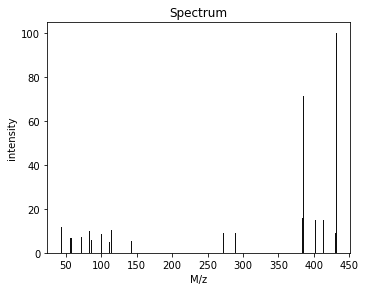

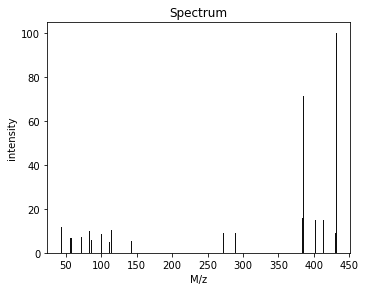

In [49]:
bt_spectra[0].plot()


## Spectra data normalisation

In [50]:
#biotransformed spectra as query
reference_spectra_bt = [filtering.remove_peaks_around_precursor_mz
                 (filtering.normalize_intensities(
                     filtering.default_filters(spec)))
                     for spec in fomated_bt_spectra]
len(reference_spectra_bt)

Removed formula N1C2CCC1CC(O)C2 from compound name.
Added formula N1C2CCC1CC(O)C2 to metadata.
Removed formula N1C2CCC1CC(O)C2 from compound name.
Added formula N1C2CCC1CC(O)C2 to metadata.
Removed formula N1C2CCC1CC(O)C2 from compound name.
Added formula N1C2CCC1CC(O)C2 to metadata.
Removed formula N1C2CCC1CC(O)(C2)O from compound name.
Added formula N1C2CCC1CC(O)(C2)O to metadata.
Removed formula N1C2CCC1CC(O)(C2)O from compound name.
Added formula N1C2CCC1CC(O)(C2)O to metadata.
Removed formula N1C2CCC1CC(O)(C2)O from compound name.
Added formula N1C2CCC1CC(O)(C2)O to metadata.
Removed formula CN1C2CCC1CC(O)(C2)O from compound name.
Added formula CN1C2CCC1CC(O)(C2)O to metadata.
Removed formula CN1C2CCC1CC(O)(C2)O from compound name.
Added formula CN1C2CCC1CC(O)(C2)O to metadata.
Removed formula CN1C2CCC1CC(O)(C2)O from compound name.
Added formula CN1C2CCC1CC(O)(C2)O to metadata.
Removed formula CN1C2CCC1CC(O)C2 from compound name.
Added formula CN1C2CCC1CC(O)C2 to metadata.
Remove

19110

## Spectra Comparision

In [51]:
query_spectra = g_spectra

In [52]:
greedy_scores = []
for qs in tqdm(query_spectra):
    for rs in reference_spectra_bt:
        if abs(qs.metadata['precursor_mz'] - rs.metadata['precursor_mz']) > 2:        
#        if abs(rs.metadata['precursor_mz'] - qs.metadata['precursor_mz']) > 2:
            continue
        score = cosine(qs, rs, 0.2, False)
        #greedy_scores.append((rs.metadata.get('title') + '_' + str(len(rs.peaks.mz)), rs, score[0], len(score[1])))
        greedy_scores.append((qs.metadata.get('compound_name') + '_' + str(len(qs.peaks.mz)), qs, score[0], len(score[1])))

  0%|          | 0/1475 [00:00<?, ?it/s]

In [53]:
greedy_scores = pd.DataFrame(greedy_scores, columns = ['query_id','query_spec','score','number_matching_fragments'])
greedy_scores.shape

(133506, 4)

In [54]:
greedy_scores.head(2)

,query_id,query_spec,score,number_matching_fragments
0,Unknown_18,<matchms.Spectrum.Spectrum object at 0x0000022...,0.052871,1
1,Unknown_18,<matchms.Spectrum.Spectrum object at 0x0000022...,0.045163,1


## output 1

In [55]:
selection_greedy = greedy_scores[(greedy_scores.score > 0.7) & (
    greedy_scores.number_matching_fragments > 0)].drop_duplicates(subset='query_id')
len(selection_greedy)

32

In [56]:
with open('./MSDIAL_OUTPUT/P2_N/True_identified_biotransformed_combined_pn.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy.query_spec.apply(to_dict).values, f_out)
f_out.close()

# True identified biotransformed spectra
true_iden_biot_spectra = selection_greedy.query_spec.to_list()
len(true_iden_biot_spectra)

32

## output 2

In [57]:
selection_greedy = greedy_scores[(greedy_scores.score < 0.7) & (
    greedy_scores.number_matching_fragments < 5)].drop_duplicates(subset='query_id')
len(selection_greedy)

1225

In [58]:
with open('./MSDIAL_OUTPUT/P2_N/Unknown_combined_pn.mgf', "w", encoding="utf-8") as f_out:
        py_mgf.write(selection_greedy.query_spec.apply(to_dict).values, f_out)
f_out.close()

# Unknown spectra
iden_unknown_spectra = selection_greedy.query_spec.to_list()
len(iden_unknown_spectra)

1225

In [59]:
iden_unknown_spectra[0].metadata

{'Alignment ID': 6,
 'precursor_mz': 102.95654,
 'retentiontime': 1.007,
 'compound_name': 'Unknown',
 'precursortype': '[M-H]-',
 'ionmode': 'n/a',
 'charge': 0}

## format output 2 according to sirius

In [60]:
sirius_input_spectra =[]
for spec in iden_unknown_spectra:
    metadata = spec.metadata
    metadata['PEPMASS'] = metadata.pop('precursor_mz')
    metadata['CHARGE'] = metadata.pop('charge') 
    sirius_input_spectra.append(Spectrum(mz=spec.peaks.mz,
                            intensities=spec.peaks.mz,
                            metadata=metadata))
len(sirius_input_spectra )

1225

In [61]:
sirius_input_spectra[0].metadata

{'Alignment ID': 6,
 'retentiontime': 1.007,
 'compound_name': 'Unknown',
 'precursortype': '[M-H]-',
 'ionmode': 'n/a',
 'PEPMASS': 102.95654,
 'CHARGE': 0}

In [62]:
with open('./MSDIAL_OUTPUT/P2_N/P2_sirius_input_spectra.mgf', "w", encoding="utf-8") as f_out:
    for i in tqdm(sirius_input_spectra):
        #print(spectra.index(spectrum))
        #i.plot()
        #print(i.peaks.intensities)
        #print(i.peaks.mz)
        spectrum_dict = {"m/z array": i.peaks.mz,
                             "intensity array": i.peaks.intensities,
                             "params": i.metadata}
        py_mgf.write([spectrum_dict], f_out)
f_out.close()


  0%|          | 0/1225 [00:00<?, ?it/s]

# Run sirius

## run this command

./bin/sirius --input demo-data/mgf/P2_sirius_input_spectra.mgf --output P2_output formula -p orbitrap structure

In [85]:
#%run pylibmassfiles/src/converter.py -o C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_output.mat C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_sirius_input_spectra.mgf

# Run MS-Finder

In [1]:
!C:/Users/kunda/Downloads/Msfinder/MsfinderConsoleApp.exe predict -i C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_output -o C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_output -m C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/MsfinderConsoleApp-Param.txt

In [2]:
!C:/Users/kunda/Downloads/Msfinder/MsfinderConsoleApp.exe mssearch -i C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_output -o C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/P2_output -m C:/Users/kunda/Liver/MSDIAL_OUTPUT/P2_N/MsfinderConsoleApp-Param.txt